In [18]:
import os
import hashlib
from collections import Counter

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from PIL import Image, ImageStat

In [19]:
data_dir = "/kaggle/input/face-mask-lite-dataset"

In [20]:
sample_image_path = os.path.join(data_dir, os.listdir(data_dir)[0], os.listdir(os.path.join(data_dir, os.listdir(data_dir)[0]))[0])

In [21]:
# === 1. Kiểm tra cấu trúc thư mục === #
def count_images(data_dir):
    class_counts = Counter()
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))])
    return class_counts

class_counts = count_images(data_dir)
class_counts

Counter({'without_mask': 10000, 'with_mask': 10000})

Lớp: without_mask


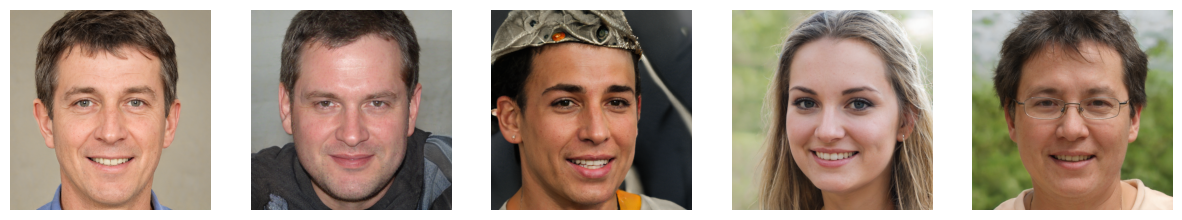

Lớp: with_mask


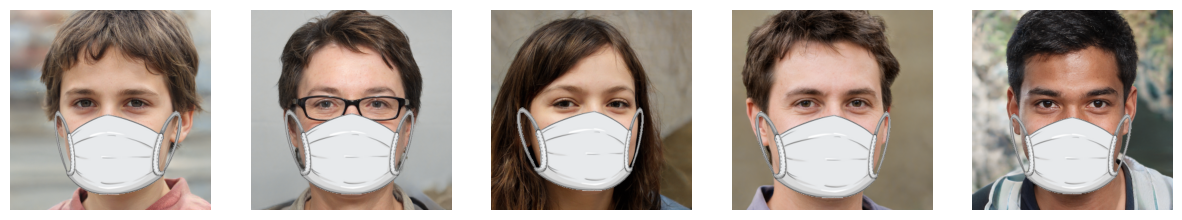

In [22]:
# === 2. Hiển thị mẫu ảnh từ từng lớp === #
def show_samples(data_dir, num_samples=5):
    classes = os.listdir(data_dir)
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
            print(f"Lớp: {class_name}")
            fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
            for i, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)[..., ::-1]
                axes[i].imshow(img)
                axes[i].axis('off')
            plt.show()

show_samples(data_dir)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


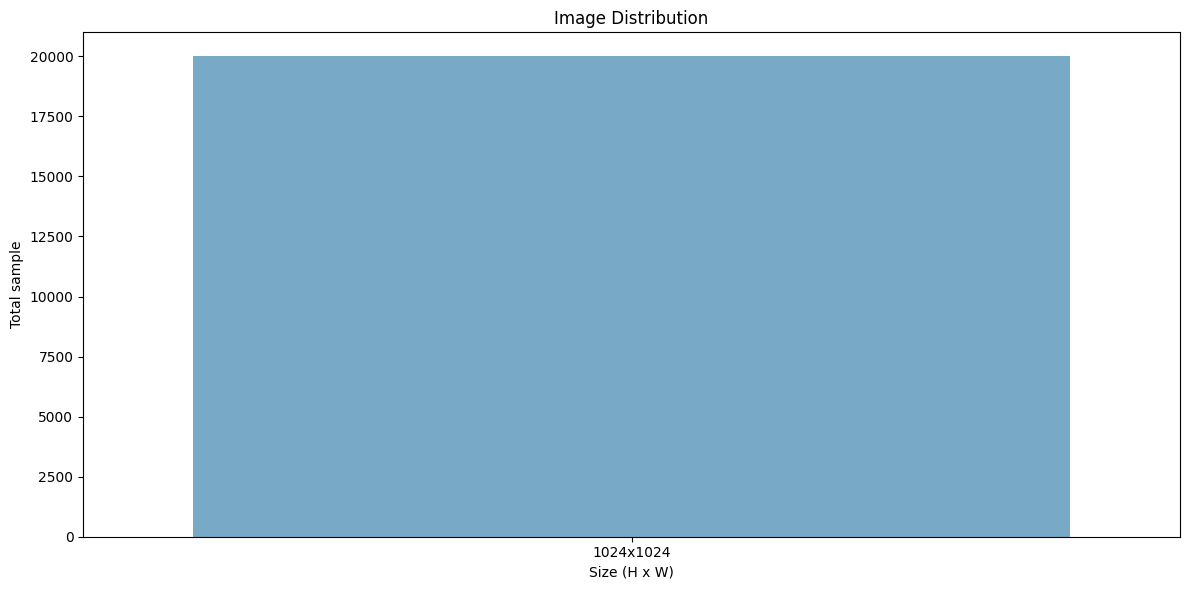

In [23]:
# === 3. Phân tích kích thước ảnh === #
def check_image_sizes(data_dir):
    sizes = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    sizes.append(img.shape[:2])
    return Counter(sizes)

image_sizes = check_image_sizes(data_dir)

plt.figure(figsize=(12, 6))
sizes_labels = [f"{size[0]}x{size[1]}" for size in image_sizes.keys()]
counts = list(image_sizes.values())
sns.barplot(x=sizes_labels, y=counts, palette="Blues")
plt.title("Image Distribution")
plt.xlabel("Size (H x W)")
plt.ylabel("Total sample")
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


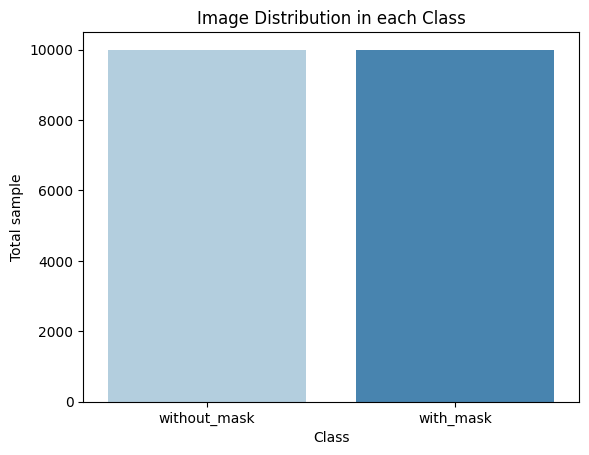

In [24]:
# === 4. Hiển thị phân bố số lượng ảnh === #
def plot_class_distribution(class_counts):
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Blues")  # Đổi palette thành "Blues"
    plt.title("Image Distribution in each Class")
    plt.xlabel("Class")
    plt.ylabel("Total sample")
    plt.show()

plot_class_distribution(class_counts)

In [25]:
# === 5. Kiểm tra dữ liệu bị lỗi === #
def check_corrupted_images(data_dir):
    corrupted = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        corrupted.append(img_path)
                except Exception as e:
                    corrupted.append(img_path)
    return corrupted

corrupted_images = check_corrupted_images(data_dir)
print(f"Number of corrupted image: {len(corrupted_images)}")

Number of corrupted image: 0


In [26]:
# === 6. Phát hiện các ảnh trùng lặp (Duplicate Images) === #
def find_duplicates(data_dir):
    hash_map = {}
    duplicates = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_name)
                try:
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    if file_hash in hash_map:
                        duplicates.append((img_path, hash_map[file_hash]))
                    else:
                        hash_map[file_hash] = img_path
                except Exception as e:
                    print(f"Không thể xử lý {img_path}: {e}")
    return duplicates

duplicates = find_duplicates(data_dir)
print(f"Number of duplicated image: {len(duplicates)}")

Number of duplicated image: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


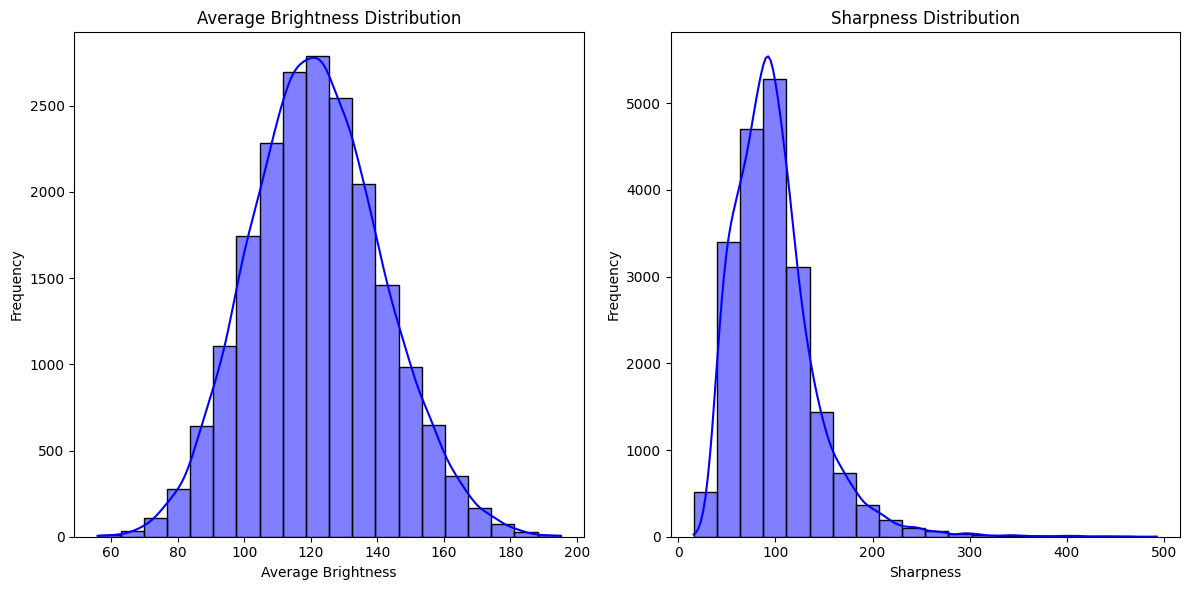

In [27]:
# === 7. Phân tích độ sáng trung bình và độ sắc nét === #
def calculate_brightness_and_sharpness(img_path):
    img = Image.open(img_path).convert("L")
    brightness = ImageStat.Stat(img).mean[0]
    img_array = np.array(img, dtype=np.float32)
    laplacian_var = cv2.Laplacian(img_array, cv2.CV_32F).var()
    return brightness, laplacian_var

def analyze_brightness_and_sharpness(data_dir):
    brightness_list = []
    sharpness_list = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.endswith((".png", ".jpg", ".jpeg")):
                brightness, sharpness = calculate_brightness_and_sharpness(img_path)
                brightness_list.append(brightness)
                sharpness_list.append(sharpness)
    return brightness_list, sharpness_list

brightness_list, sharpness_list = analyze_brightness_and_sharpness(data_dir)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(brightness_list, kde=True, bins=20, color="blue")
plt.title("Average Brightness Distribution")
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(sharpness_list, kde=True, bins=20, color="blue")
plt.title("Sharpness Distribution")
plt.xlabel("Sharpness")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Dominant Colors (RGB):
Color 1: [196 138 112]
Color 2: [171 161 143]
Color 3: [58 42 33]
Color 4: [229 173 149]
Color 5: [123  92  75]


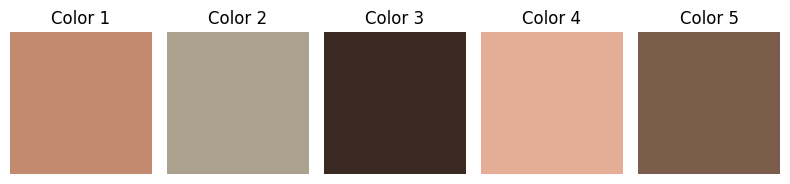

In [28]:
# === 8. Phân tích tần suất màu sắc chủ đạo === #
def analyze_dominant_colors(img_path, k=3):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    return dominant_colors

dominant_colors = analyze_dominant_colors(sample_image_path, k=5)

print("Dominant Colors (RGB):")
for idx, color in enumerate(dominant_colors):
    print(f"Color {idx + 1}: {color}")

plt.figure(figsize=(8, 4))
for idx, color in enumerate(dominant_colors):
    plt.subplot(1, len(dominant_colors), idx + 1)
    plt.imshow([[color / 255.0]])
    plt.axis("off")
    plt.title(f"Color {idx + 1}")
plt.tight_layout()
plt.show()

Total sample: 20000
Average Texture Variance: 98.93
Texture Standard Deviation: 43.02


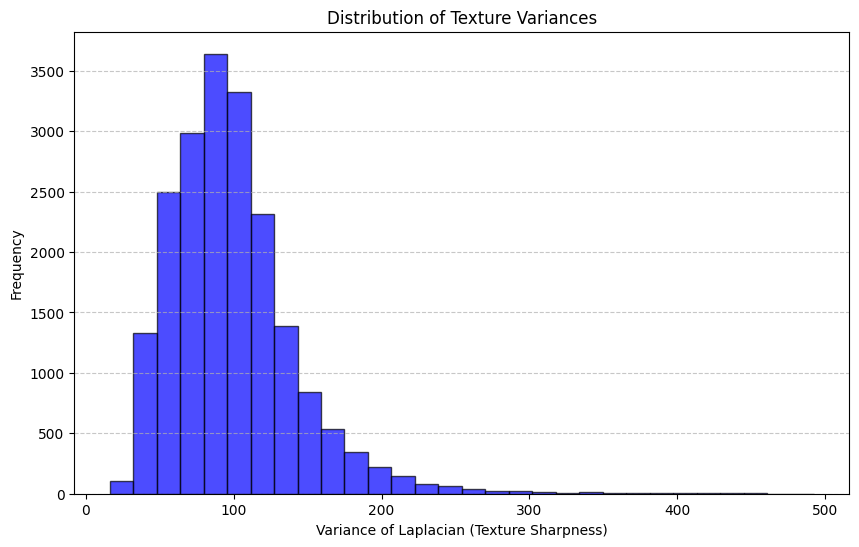

In [29]:
# === 9. Phân tích texture === #
def analyze_texture(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    return np.var(laplacian)

texture_variances = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if img_name.endswith((".png", ".jpg", ".jpeg")):
            texture_var = analyze_texture(img_path)
            if texture_var is not None:
                texture_variances.append(texture_var)

print(f"Total sample: {len(texture_variances)}")
print(f"Average Texture Variance: {np.mean(texture_variances):.2f}")
print(f"Texture Standard Deviation: {np.std(texture_variances):.2f}")

plt.figure(figsize=(10, 6))
plt.hist(texture_variances, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Texture Variances")
plt.xlabel("Variance of Laplacian (Texture Sharpness)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

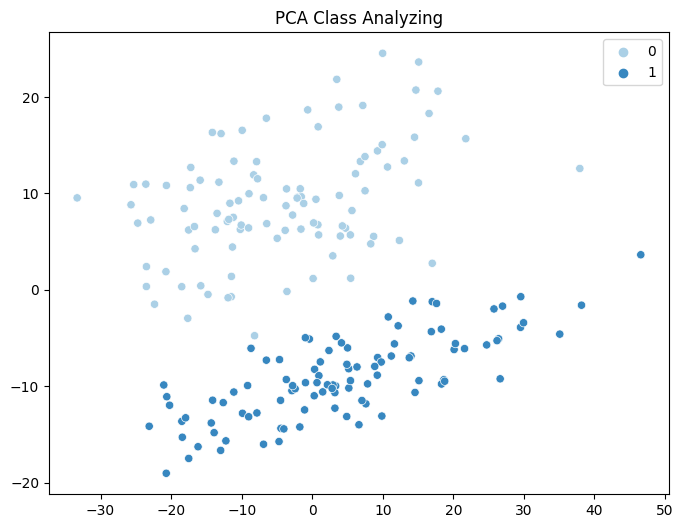

In [30]:
# === 9. Phân tích phân tách lớp === #
def extract_features_for_visualization(data_dir, num_samples=100):
    features = []
    labels = []
    for class_label, class_name in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path)[:num_samples]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (32, 32)).flatten()
            features.append(img_resized)
            labels.append(class_label)
    return np.array(features), np.array(labels)

features, labels = extract_features_for_visualization(data_dir)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=labels, palette='Blues')
plt.title("PCA Class Analyzing")
plt.show()

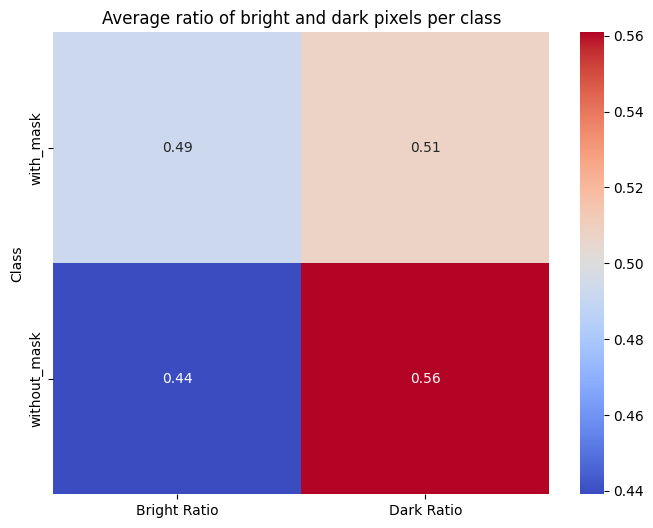

In [31]:
# === 10. Phân tích sự phân bố của nhiều ảnh === #
def analyze_pixel_intensity(img_path, threshold=128):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    total_pixels = img.size
    bright_pixels = np.sum(img > threshold)
    dark_pixels = np.sum(img <= threshold)
    return bright_pixels / total_pixels, dark_pixels / total_pixels

def analyze_pixel_intensity_for_all(data_dir, threshold=128):
    results = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            bright_ratio, dark_ratio = analyze_pixel_intensity(img_path, threshold)
            results.append({"Class": class_name, "Bright Ratio": bright_ratio, "Dark Ratio": dark_ratio})
    return pd.DataFrame(results)

pixel_intensity_df = analyze_pixel_intensity_for_all(data_dir)

heatmap_data = pixel_intensity_df.groupby("Class")[["Bright Ratio", "Dark Ratio"]].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True)
plt.title("Average ratio of bright and dark pixels per class")
plt.show()

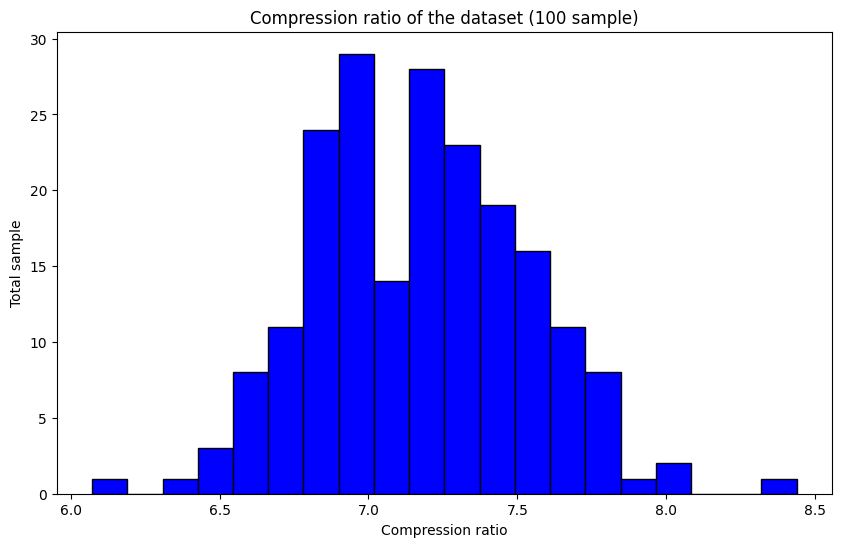

In [32]:
# === 11. Phân tích tỉ lệ nén ảnh === #
def calculate_compression_ratio(img_path):
    original_size = os.path.getsize(img_path)
    img = cv2.imread(img_path)
    _, compressed_img = cv2.imencode('.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, 90])
    compressed_size = len(compressed_img.tobytes())
    return original_size / compressed_size

def get_compression_ratios(data_dir, num_samples=100):
    compression_ratios = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path)[:num_samples]:
            img_path = os.path.join(class_path, img_name)
            compression_ratio = calculate_compression_ratio(img_path)
            compression_ratios.append(compression_ratio)
    return compression_ratios
    
compression_ratios = get_compression_ratios(data_dir)

plt.figure(figsize=(10, 6))
plt.hist(compression_ratios, bins=20, color='blue', edgecolor='black')
plt.title('Compression ratio of the dataset (100 sample)')
plt.xlabel('Compression ratio')
plt.ylabel('Total sample')
plt.show()


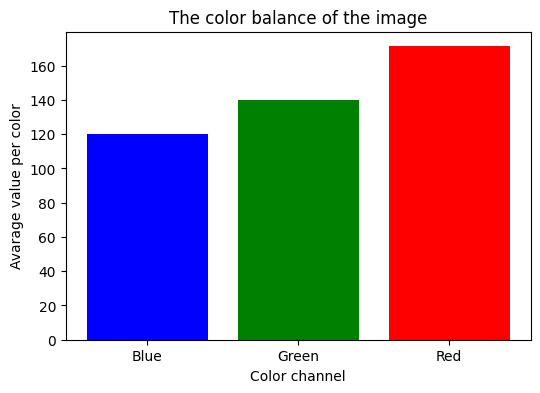

In [34]:
# === 12. Phân tích sự cân bằng màu sắc === #
def analyze_color_balance(img_path):
    img = cv2.imread(img_path)
    b_mean, g_mean, r_mean = cv2.mean(img)[:3]
    return {"Blue": b_mean, "Green": g_mean, "Red": r_mean}

color_balance = analyze_color_balance(sample_image_path)

def plot_color_balance(color_balance):
    plt.figure(figsize=(6, 4))
    plt.bar(color_balance.keys(), color_balance.values(), color=['blue', 'green', 'red'])
    plt.title('The color balance of the image')
    plt.xlabel('Color channel')
    plt.ylabel('Avarage value per color')
    plt.show()

plot_color_balance(color_balance)